In [1]:
# Setup
import torch

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 0.001

# Online Continual Learning Evaluation

In this notebook, you will be introduced to online continual learning and **catastrophic forgetting**.

## Data Streams

In this section, we introduce some built-in data streams that can be used for online continual learning evaluation. CapyMOA currently only supports class/task incremental learning with disjoint tasks.


In [2]:
from capymoa.ocl.datasets import SplitMNIST

scenario = SplitMNIST()
for task_id, task_classes in enumerate(scenario.task_schedule):
    print(f"Task {task_id} classes: {task_classes}")

Task 0 classes: {1, 4}
Task 1 classes: {5, 7}
Task 2 classes: {9, 3}
Task 3 classes: {0, 8}
Task 4 classes: {2, 6}


You can access each task separately as a dataset or as a single stream.

In [3]:
print(scenario.train_tasks)
print(scenario.test_tasks)
print(scenario.stream)

[<torch.utils.data.dataset.Subset object at 0x7d39648db890>, <torch.utils.data.dataset.Subset object at 0x7d39648db560>, <torch.utils.data.dataset.Subset object at 0x7d3744871010>, <torch.utils.data.dataset.Subset object at 0x7d374489e2a0>, <torch.utils.data.dataset.Subset object at 0x7d374489f110>]
[<capymoa.ocl.datasets._PreloadedDataset object at 0x7d374489f260>, <capymoa.ocl.datasets._PreloadedDataset object at 0x7d374489eed0>, <capymoa.ocl.datasets._PreloadedDataset object at 0x7d374489f2c0>, <capymoa.ocl.datasets._PreloadedDataset object at 0x7d374489eb10>, <capymoa.ocl.datasets._PreloadedDataset object at 0x7d374484aa50>]


## Classifier

In this section, we introduce the `BatchClassifier` classes, that all OCL methods inherit from. You can reuse any classifier for regular online learning as well.

In [4]:
import torch
from capymoa.base import BatchClassifier
from capymoa.stream import Schema
from torch import nn
from torch.nn import functional as F


class BasicMLP(BatchClassifier):
    def __init__(self, schema: Schema, random_seed: int = 1):
        super().__init__(schema, random_seed)
        self.device = device
        self.model = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(schema.get_num_attributes(), 128),
            nn.ReLU(),
            nn.Linear(128, schema.get_num_classes()),
        ).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def batch_train(self, x: torch.Tensor, y: torch.Tensor) -> None:
        self.model.train()
        self.optimizer.zero_grad()
        output = self.model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        self.optimizer.step()

    def batch_predict_proba(self, x: torch.Tensor) -> torch.Tensor:
        self.model.eval()
        with torch.no_grad():
            output = self.model(x)
            return F.softmax(output, dim=1)

## Evaluation

### Online Evaluation

![online evaluation schematic](img/01_ocl_compared.png)

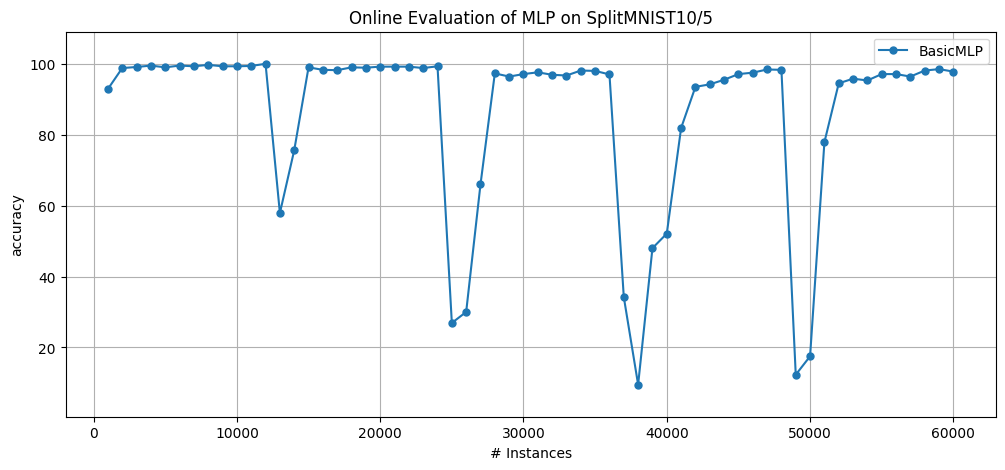

In [ ]:
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

results = prequential_evaluation(
    scenario.stream, BasicMLP(scenario.schema), batch_size=batch_size
)
plot_windowed_results(results, metric="accuracy", plot_title=f"Online Evaluation of MLP on {scenario}", save_only=False)

### OCL Evaluation

![continual learning evaluation schematic](img/03_ocl_compared.png)



Train & Eval:   0%|          | 0/1144 [00:00<?, ?it/s]

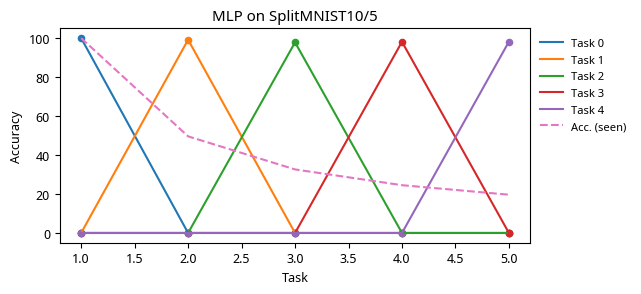

In [ ]:
from capymoa.ocl.evaluation import ocl_train_eval_loop
from plot import ocl_plot

result = ocl_train_eval_loop(
    BasicMLP(scenario.schema),
    scenario.train_loaders(batch_size),
    scenario.test_loaders(256),
    progress_bar=True,
)
fig, ax = ocl_plot(result, acc_seen=True)
ax.set_title(f"MLP on {scenario}")
pass

Catastrophic forgetting is very severe!

### Anytime OCL Evaluation


Train & Eval:   0%|          | 0/2989 [00:00<?, ?it/s]

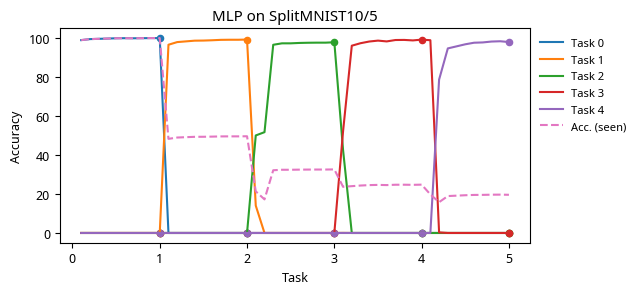

In [ ]:
result = ocl_train_eval_loop(
    BasicMLP(scenario.schema),
    scenario.train_loaders(batch_size),
    scenario.test_loaders(256),
    continual_evaluations=10,
    progress_bar=True,
)
fig, ax = ocl_plot(result, acc_seen=True)
ax.set_title(f"MLP on {scenario}")
pass

### Forward and Backwards Transfer

In [8]:
print(f"Forward Transfer:  {result.forward_transfer * 100:.1f}")
print(f"Backward Transfer: {result.backward_transfer * 100:.1f}")

Forward Transfer:  0.0
Backward Transfer: -99.1


## Online Task Incremental Learning

We support task incremental learners by inheriting from `TestTaskAware`. The evaluation function will call `on_test_task` for each task in the stream. Likewise for `TrainTaskAware`. Generally being `TrainTaskAware` is more realistic than being `TestTaskAware`.


In [9]:
from capymoa.ocl.base import TestTaskAware, TrainTaskAware


class MultiHeadMLPModel(nn.Module):
    def __init__(self, in_features: int, out_features: int, n_tasks: int):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 128),
            nn.ReLU(),
        )
        self.heads = nn.ModuleList(
            [nn.Linear(128, out_features) for _ in range(n_tasks)]
        )

    def forward(self, x: torch.Tensor, task_id: int) -> torch.Tensor:
        x = self.shared(x)
        return self.heads[task_id](x)


class MultiHeadMLP(BatchClassifier, TrainTaskAware, TestTaskAware):
    def __init__(self, schema: Schema, n_tasks: int, random_seed: int = 1):
        super().__init__(schema, random_seed)
        self.device = device
        self.model = MultiHeadMLPModel(
            schema.get_num_attributes(),
            schema.get_num_classes(),
            n_tasks,
        ).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.task_id = 0

    # NEW:
    def on_train_task(self, task_id: int):
        self.task_id = task_id

    # NEW:
    def on_test_task(self, task_id: int):
        self.task_id = task_id

    def batch_train(self, x: torch.Tensor, y: torch.Tensor) -> None:
        self.model.train()
        self.optimizer.zero_grad()
        output = self.model.forward(x, self.task_id)
        loss = F.cross_entropy(output, y)
        loss.backward()
        self.optimizer.step()

    def batch_predict_proba(self, x: torch.Tensor) -> torch.Tensor:
        self.model.eval()
        with torch.no_grad():
            output = self.model.forward(x, self.task_id)
            return F.softmax(output, dim=1)

Train & Eval:   0%|          | 0/2989 [00:00<?, ?it/s]

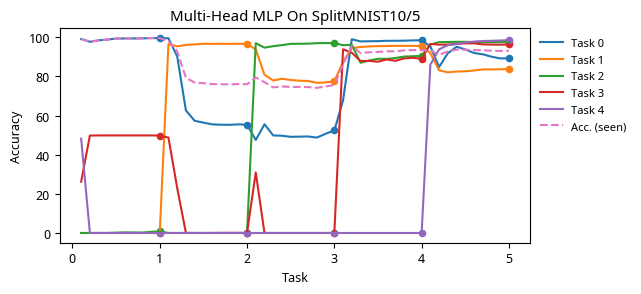

In [10]:
result = ocl_train_eval_loop(
    MultiHeadMLP(scenario.schema, 5),
    scenario.train_loaders(batch_size),
    scenario.test_loaders(256),
    continual_evaluations=10,
    progress_bar=True,
)
fig, ax = ocl_plot(
    result,
    acc_seen=True,
)
ax.set_title(f"Multi-Head MLP On {scenario}")
pass